In [1]:
import d2lzh as d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn




In [2]:
#create dataset
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2),
                          nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)




In [3]:
features[:2], poly_features[:2], labels[:2]



(
 [[1.1630785]
  [0.4838046]]
 <NDArray 2x1 @cpu(0)>,
 
 [[1.1630785  1.3527517  1.5733565 ]
  [0.4838046  0.2340669  0.11324265]]
 <NDArray 2x3 @cpu(0)>,
 
 [10.534649  5.530093]
 <NDArray 2 @cpu(0)>)

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)



In [5]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
          '\nbias:', net[0].bias.data().asnumpy())



final epoch: train loss 0.0068647712 test loss 0.0062667388
weight: [[ 1.1793793 -3.3932073  5.6032877]] 
bias: [4.988133]


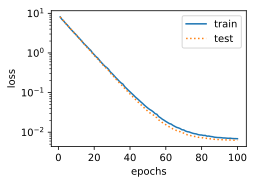

In [6]:
#normal
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])



final epoch: train loss 159.33257 test loss 102.94957
weight: [[22.656803]] 
bias: [-0.6577304]


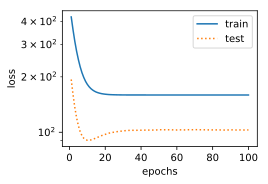

In [7]:
#underfit
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])


final epoch: train loss 0.47576833 test loss 133.27454
weight: [[2.0588458 1.9273669 2.0477402]] 
bias: [2.482129]


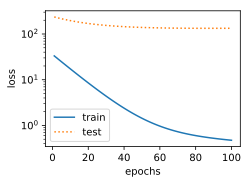

In [8]:
#overfit
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])



In [9]:
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]



In [10]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]


In [11]:
def l2_penalty(w):
    return (w**2).sum() / 2



In [12]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # 添加了L2范数惩罚项，广播机制使其变成长度为batch_size的向量
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())



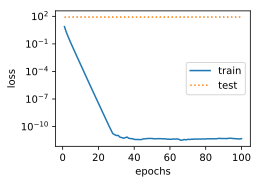

L2 norm of w: 13.361743


In [13]:
#overfit
fit_and_plot(lambd=0)



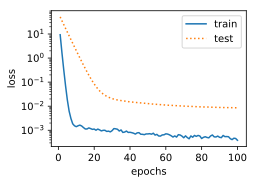

L2 norm of w: 0.042202767


In [14]:
#use weight decay
fit_and_plot(lambd=3)



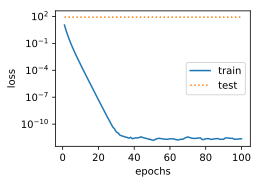

L2 norm of w: 14.187615


In [15]:
#simple implement
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称一般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调用step函数，从而分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())
    

fit_and_plot_gluon(0)





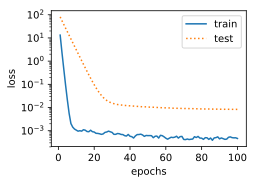

L2 norm of w: 0.03968708


In [16]:
fit_and_plot_gluon(3)



In [17]:
#正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
#权重衰减等价于 L2 范数正则化，通常会使学到的权重参数的元素较接近0。
# 权重衰减可以通过Gluon的wd超参数来指定。
# 可以定义多个Trainer实例对不同的模型参数使用不同的迭代方法。


In [18]:
#use dropout to avoid overfit
from mxnet.gluon import loss as gloss, nn

def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return X.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape) < keep_prob
    return mask * X / keep_prob



In [19]:
X = nd.arange(16).reshape((2, 8))
dropout(X, 0)




[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
<NDArray 2x8 @cpu(0)>

In [20]:
dropout(X, 0.5)




[[ 0.  2.  4.  6.  0. 10.  0.  0.]
 [ 0.  0.  0.  0. 24. 26. 28.  0.]]
<NDArray 2x8 @cpu(0)>

In [21]:
dropout(X,1)




[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 2x8 @cpu(0)>

In [22]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()



In [23]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X, W1) + b1).relu()
    if autograd.is_training():  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (nd.dot(H1, W2) + b2).relu()
    if autograd.is_training():
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return nd.dot(H2, W3) + b3



In [24]:
num_epochs, lr, batch_size = 5, 0.5, 256
loss = gloss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params, lr)



epoch 1, loss 1.1595, train acc 0.553, test acc 0.786
epoch 2, loss 0.5703, train acc 0.788, test acc 0.836
epoch 3, loss 0.4883, train acc 0.820, test acc 0.853
epoch 4, loss 0.4495, train acc 0.837, test acc 0.853
epoch 5, loss 0.4204, train acc 0.846, test acc 0.862


In [25]:
#simple implement
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
        nn.Dropout(drop_prob1),  # 在第一个全连接层后添加丢弃层
        nn.Dense(256, activation="relu"),
        nn.Dropout(drop_prob2),  # 在第二个全连接层后添加丢弃层
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None,
              None, trainer)



epoch 1, loss 1.1234, train acc 0.557, test acc 0.786
epoch 2, loss 0.5735, train acc 0.786, test acc 0.840
epoch 3, loss 0.4879, train acc 0.823, test acc 0.832
epoch 4, loss 0.4447, train acc 0.838, test acc 0.824
epoch 5, loss 0.4150, train acc 0.849, test acc 0.859


In [ ]:
# 正向传播沿着从输入层到输出层的顺序，依次计算并存储神经网络的中间变量。
# 反向传播沿着从输出层到输入层的顺序，依次计算并存储神经网络的中间变量和参数的梯度。
# 在训练深度学习模型时，正向传播和反向传播相互依赖

